In [51]:
import pandas as pd
import csv
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

In [52]:
movie_file = Path("../Data/final_1688.csv")

movie_df = pd.read_csv(movie_file)

movie_df['Director_O'] = movie_df['Director_O'].str.replace('Directors:', '')
movie_df.head()

,title,revenue,budget,profit,main_genre,Runtime(Mins),Year,original_language,Director_O,Actors_O,Rating,Metascore_O,Rotten_Tomato_O,Award Wins,Award Nominations
0,Inception,825532764,160000000,665532764,Action,148.0,2010.0,en,Christopher Nolan,"Leonardo DiCaprio, Joseph Gordon-Levitt, Ellio...",8.8,74.0,87%,159.0,220.0
1,Interstellar,701729206,165000000,536729206,Adventure,169.0,2014.0,en,Christopher Nolan,"Matthew McConaughey, Anne Hathaway, Jessica Ch...",8.6,74.0,73%,0.0,0.0
2,The Dark Knight,1004558444,185000000,819558444,Action,152.0,2008.0,en,Christopher Nolan,"Christian Bale, Heath Ledger, Aaron Eckhart",9.0,84.0,94%,163.0,164.0
3,Avatar,2923706026,237000000,2686706026,Action,162.0,2009.0,en,James Cameron,"Sam Worthington, Zoe Saldana, Sigourney Weaver",7.8,83.0,82%,91.0,131.0
4,The Avengers,1518815515,220000000,1298815515,Action,143.0,2012.0,en,Joss Whedon,"Robert Downey Jr., Chris Evans, Scarlett Johan...",8.0,69.0,91%,39.0,81.0


In [53]:
movie_df.rename(columns={'Director_O': 'Director',
                   'Actors_O': 'Actors',
                   'Metascore_O': 'Metascore',
                   "Rotten_Tomato_O": "Rotten_Tomatoes"}, inplace=True)

#Filtering (Cleaning) movie_df

df_unique = movie_df.drop_duplicates(subset='title', keep='first')
filter_criteria = (
    (df_unique['Metascore'].notna()) &
    (df_unique['revenue'].notna()) &
    (df_unique['Metascore'] != 'Rating not found') &
    (df_unique['revenue'] != 'Box Office not found')
)
clean_director_df = df_unique[filter_criteria]
clean_director_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1582 entries, 0 to 1628
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              1582 non-null   object 
 1   revenue            1582 non-null   int64  
 2   budget             1582 non-null   int64  
 3   profit             1582 non-null   int64  
 4   main_genre         1582 non-null   object 
 5   Runtime(Mins)      1582 non-null   float64
 6   Year               1582 non-null   float64
 7   original_language  1582 non-null   object 
 8   Director           1582 non-null   object 
 9   Actors             1582 non-null   object 
 10  Rating             1582 non-null   float64
 11  Metascore          1582 non-null   float64
 12  Rotten_Tomatoes    1582 non-null   object 
 13  Award Wins         1582 non-null   float64
 14  Award Nominations  1582 non-null   float64
dtypes: float64(6), int64(3), object(6)
memory usage: 197.8+ KB


### The input cell below groups the data by "Single Director" and "Multiple Directors"

In [54]:
# Create a new column "Director_Type" based on the number of directors
clean_director_df['Director_Type'] = clean_director_df['Director'].apply(lambda x: 'Multiple Directors' if ',' in x else 'Single Director')

# Group the DataFrame by the "Director_Type" column
grouped_director_type = clean_director_df.groupby('Director_Type')

grouped_director_type

### The input cell below splits "Multiple Directors" into individual elements

In [55]:
# Identify rows with multiple directors
multiple_directors_mask = clean_director_df['Director'].str.contains(',')

# Split multiple directors into individual values and create new rows
multiple_directors_df = clean_director_df[multiple_directors_mask].copy()
multiple_directors_df['Director'] = multiple_directors_df['Director'].str.split(', ')
multiple_directors_df = multiple_directors_df.explode('Director')

# Combine the original DataFrame with the new rows for multiple directors
updated_director_df = pd.concat([clean_director_df[~multiple_directors_mask], multiple_directors_df], ignore_index=True)

In [56]:
updated_director_df['Director_Type'].count()
#1790

1760

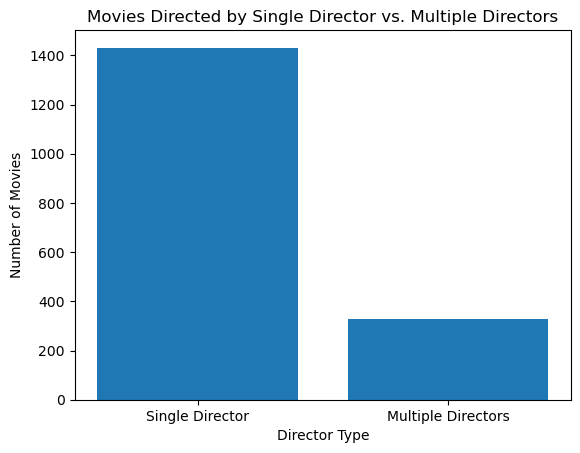

Of the ~1760 movies, 81.31% were directed by an individual director, whereas 18.69% were directed by multiple directors


In [74]:
director_counts = updated_director_df['Director_Type'].value_counts()
plt.bar(director_counts.index, director_counts.values)
plt.xlabel('Director Type')
plt.ylabel('Number of Movies')
plt.title('Movies Directed by Single Director vs. Multiple Directors')

plt.savefig("JV_Fig1_MovieCount_by_DirectorGroup.png")

plt.show()

single_director_percent = 1431 / 1760 * 100
rounded_single = round(single_director_percent, 2)
multiple_director_percent = 329 / 1760 * 100
rounded_multiple = round(multiple_director_percent, 2)
print(f"Of the ~1760 movies, {rounded_single}% were directed by an individual director, whereas {rounded_multiple}% were directed by multiple directors")


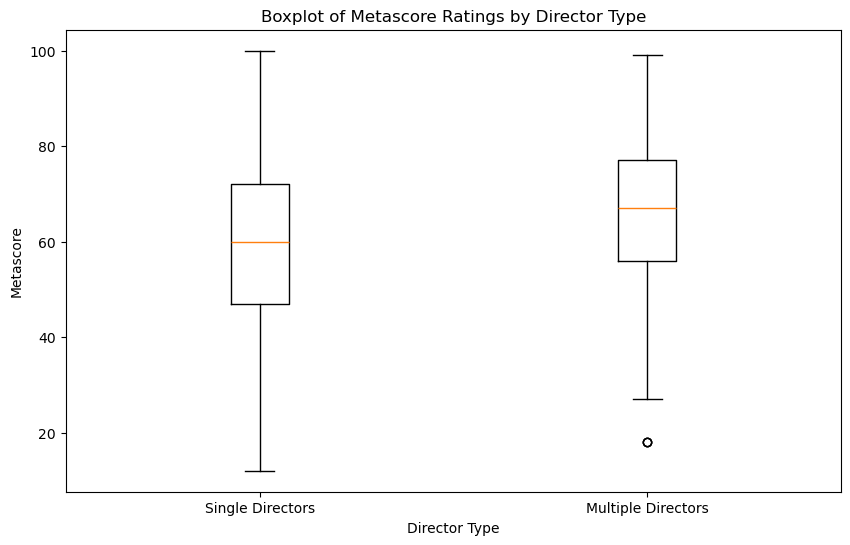

T-Statistic: -6.5897502369331145
P-Value: 5.8054621257592955e-11
Reject Null Hypothesis. There IS a significant difference in Metascore Ratings of movies directed by individuals vs. movies directed by a group of people
The mean score for movies directed by an individual was 59.98/100, whereas the mean score for movies directed by multiple directors was 66.73/100


In [75]:
# Separate the data for Single Directors and Multiple Directors
single_directors_ratings = updated_director_df[updated_director_df['Director_Type'] == 'Single Director']['Metascore']
multiple_directors_ratings = updated_director_df[updated_director_df['Director_Type'] == 'Multiple Directors']['Metascore']

# Create a boxplot
plt.figure(figsize=(10, 6))
plt.boxplot([single_directors_ratings, multiple_directors_ratings], labels=['Single Directors', 'Multiple Directors'])
plt.xlabel('Director Type')
plt.ylabel('Metascore')
plt.title('Boxplot of Metascore Ratings by Director Type')
plt.savefig("JV_Fig2_Metascore_by_DirectorGroup.png")
plt.show()
# Not sure if this is something noteable, but I'll save it just in case. Mean rating (red line) for Single Directors is 6.75, 
# while the mean rating for multiple directors is 6.84.
single_mean_score = round(single_directors_ratings.mean(),2)
multiple_mean_score = round(multiple_directors_ratings.mean(),2)
t_stat, p_value = stats.ttest_ind(single_directors_ratings,multiple_directors_ratings)
print(f"T-Statistic: {t_stat}")
print(f"P-Value: {p_value}")

alpha = 0.05
if p_value < alpha:
    print("Reject Null Hypothesis. There IS a significant difference in Metascore Ratings of movies directed by individuals vs. movies directed by a group of people")
else:
    print("Retain Null Hypothesis. There IS NOT a significant difference in Metascore Ratings between movies directed by single directors vs. multiple directors")
print(f"The mean score for movies directed by an individual was {single_mean_score}/100, whereas the mean score for movies directed by multiple directors was {multiple_mean_score}/100")



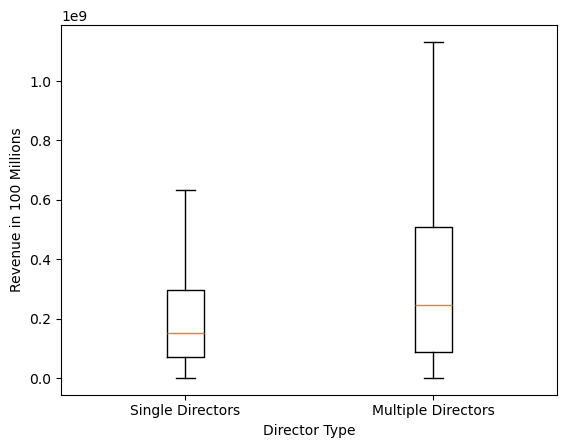

T-Statistic: -8.060698932401326
P-Value: 1.3877695958092211e-15
Reject Null Hypothesis. There IS a significant difference in Metascore Ratings of movies directed by individuals vs. movies directed by a group of people


In [59]:
# cleaned_boxoffice = clean_movie_df.loc[(clean_movie_df['revenue'] != "Metascore not found") & (clean_movie_df['Metascore'].notna())]
# cleaned_boxoffice['Metascore'] = cleaned_boxoffice['Metascore'].str.replace('[\$,]', '', regex=True).astype(int)

box_and_directortype = updated_director_df[['revenue', 'Director_Type']]

single_directors_revenue = box_and_directortype[box_and_directortype['Director_Type'] == 'Single Director']['revenue']
multiple_directors_revenue = box_and_directortype[box_and_directortype['Director_Type'] == 'Multiple Directors']['revenue']
plt.boxplot([single_directors_revenue, multiple_directors_revenue], labels=['Single Directors', 'Multiple Directors'], showfliers=False)
plt.xlabel('Director Type')
plt.ylabel('Revenue in 100 Millions')
plt.show();

t_stat, p_value = stats.ttest_ind(single_directors_revenue,multiple_directors_revenue)
print(f"T-Statistic: {t_stat}")
print(f"P-Value: {p_value}")

alpha = 0.05
if p_value < alpha:
    print("Reject Null Hypothesis. There IS a significant difference in Metascore Ratings of movies directed by individuals vs. movies directed by a group of people")
else:
    print("Retain Null Hypothesis. There IS NOT a significant difference in Metascore Ratings between movies directed by single directors vs. multiple directors")

In [60]:
# Top Directors dataframe
clean_director_df['Director']

# Split directors in cells containing multiple directors into separate rows
directors_df = clean_director_df['Director'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).rename('Director')

# Count the occurrences of each director
director_counts = directors_df.value_counts()

# Sort the directors based on the number of movies they have made
most_movies_directors = director_counts.head()


# Display the directors who made the most movies
most_movies_directors_df = most_movies_directors.reset_index()
most_movies_directors_df.columns = ['Director', 'Total Movies Directed']
most_movies_directors_df

,Director,Total Movies Directed
0,Steven Spielberg,21
1,Tim Burton,15
2,Robert Zemeckis,14
3,Martin Scorsese,13
4,Michael Bay,12


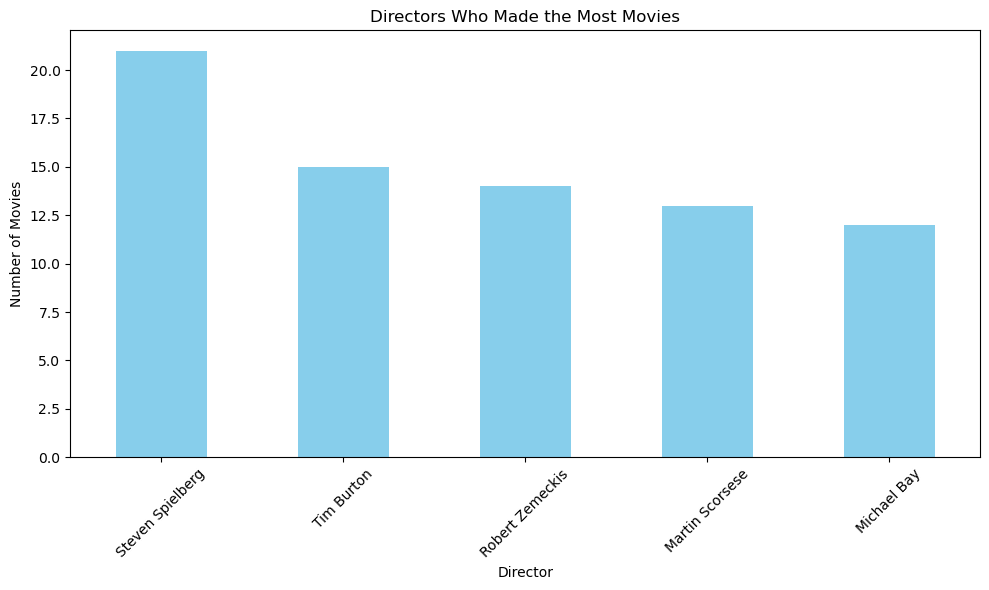

In [76]:

# Plotting the directors who made the most movies as a bar chart
plt.figure(figsize=(10, 6))
most_movies_directors.plot(kind='bar', color='skyblue')
plt.title('Directors Who Made the Most Movies')
plt.xlabel('Director')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the bar chart
plt.savefig("JV_Fig3_Top5Directors.png")
plt.show();


In [62]:
top_directors = ['Steven Spielberg', 'Tim Burton', 'Robert Zemeckis', 'Martin Scorsese', 'Michael Bay']

top_directors_df = clean_director_df[clean_director_df['Director'].str.contains('|'.join(top_directors))].sort_values(by='Director')
top_directors_df_clean = top_directors_df.assign(Director=top_directors_df['Director'].str.split(', ')).explode('Director')

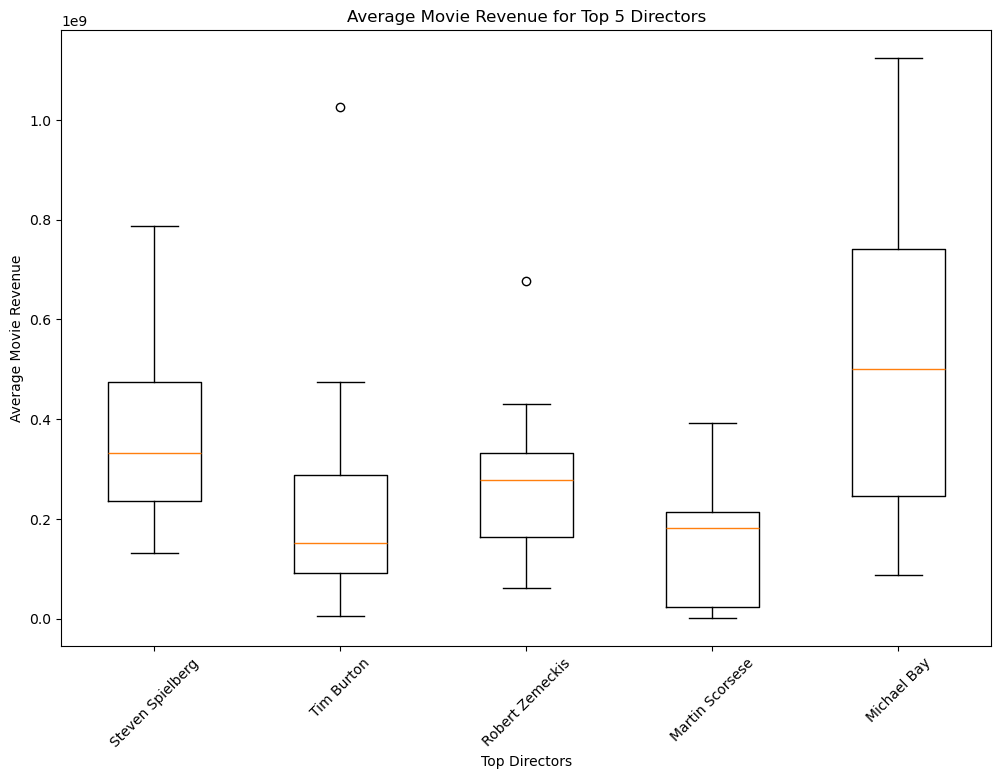

Director: Steven Spielberg, Average Revenue: $130,982,129.00
Director: Tim Burton, Average Revenue: $53,000,000.00
Director: Robert Zemeckis, Average Revenue: $161,772,375.00
Director: Martin Scorsese, Average Revenue: $2,536,000.00
Director: Michael Bay, Average Revenue: $449,220,945.00


In [77]:
# List of the top 5 directors
top_directors = ['Steven Spielberg', 'Tim Burton', 'Robert Zemeckis', 'Martin Scorsese', 'Michael Bay']

# Create a new DataFrame with rows that match the top directors
top_directors_df = clean_director_df[clean_director_df['Director'].str.contains('|'.join(top_directors))].sort_values(by='Director')

# Display the new DataFrame
top_directors_df_clean = top_directors_df.assign(Director=top_directors_df['Director'].str.split(', ')).explode('Director')

# List of directors to remove
directors_to_remove = ['Don Siegel', 'Mike Johnson']

# Filter out the directors to remove from the DataFrame
top_directors_filtered = top_directors_df_clean[~top_directors_df['Director'].isin(directors_to_remove)]

# Create a vertical box plot for the average revenue data of the top directors
plt.figure(figsize=(12, 8))
plt.boxplot([top_directors_filtered[top_directors_filtered['Director'] == director]['revenue'] for director in top_directors],
            labels=top_directors)
plt.xticks(rotation=45)
plt.xlabel('Top Directors')
plt.ylabel('Average Movie Revenue')
plt.title('Average Movie Revenue for Top 5 Directors')

plt.savefig("JV_Fig4_Revenue_by_Top5.png")
plt.show()

for director in top_directors:
    avg_revenue = top_directors_filtered.loc[top_directors_filtered['Director'] == director, 'revenue'].values[0]
    formatted_avg_revenue = "${:,.2f}".format(avg_revenue)
    print(f"Director: {director}, Average Revenue: {formatted_avg_revenue}")



In [48]:
#Finding overall mean metascore for later use in the bar graph
clean_director_df['Metascore'].mean()

60.58217446270544

In [49]:
# Getting the mean metascore by director using groupby
top_directors_df = clean_director_df[clean_director_df['Director'].isin(top_directors)]

mean_metascore_by_director = top_directors_df.groupby('Director')['Metascore'].mean()
mean_metascore_by_director

Director
Martin Scorsese     79.307692
Michael Bay         42.916667
Robert Zemeckis     66.857143
Steven Spielberg    73.142857
Tim Burton          65.142857
Name: Metascore, dtype: float64

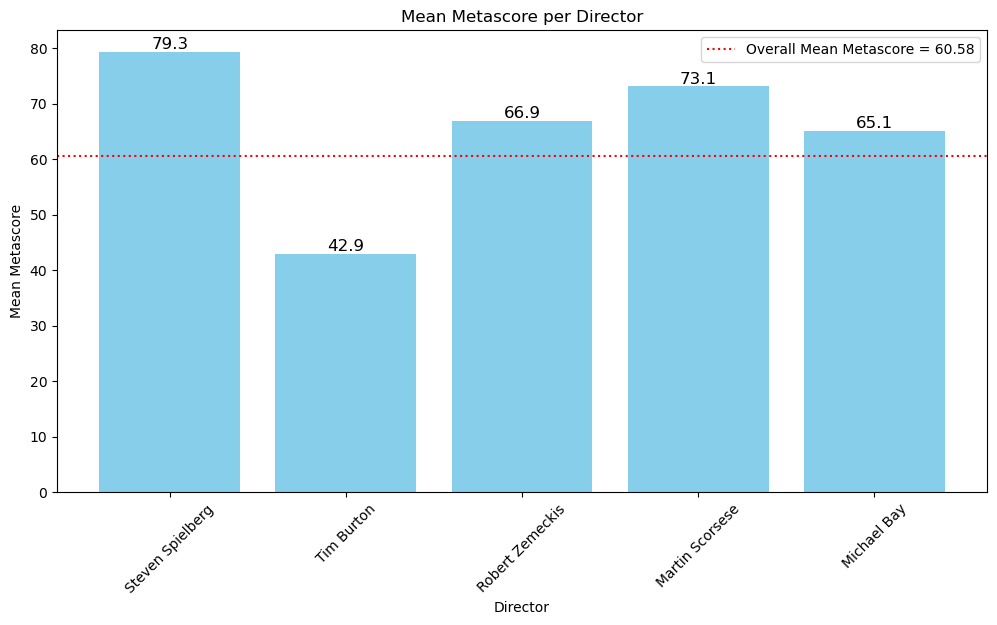

In [78]:
# Data for mean Metascore per director to be used for Bar Graph
mean_director_metascores = mean_metascore_by_director.values.tolist()

plt.figure(figsize=(12, 6))
bars = plt.bar(top_directors, mean_director_metascores, color='skyblue')
plt.xlabel('Director')
plt.ylabel('Mean Metascore')
plt.title('Mean Metascore per Director')
plt.xticks(rotation=45)

# Showing a horizontal line of the mean metascore of all movies in the clean_director_df
plt.axhline(y=60.58, color='r', linestyle=':', label='Overall Mean Metascore = 60.58')
plt.legend()

# Labelling each Bar with its corresponding Metascore value
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), va='bottom', ha='center', fontsize=12)

plt.savefig("JV_Fig5_Metascore_Top5.png")
plt.show();
